In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
import numpy as np
from adabelief_pytorch import AdaBelief
from collections import Counter
from torch.optim import lr_scheduler


from torchvision import datasets, models, transforms
import os
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from PIL import Image, ImageOps
import numpy as np
import cv2

from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm  


In [16]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.4970856163948774, 0.3660721661299467, 0.012605847830753192], 
                         [0.3098917880987543, 0.251007258041955, 0.08280670520288899])
])


In [17]:

# Assuming you have your transforms defined
data_dir = 'Data_superposed_temporalRemoved'  # Replace with your directory path

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Extract the targets (labels) from the dataset
targets = np.array([y for _, y in dataset])

# Stratified split to maintain class proportions
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the train and validation indices
train_indices, val_indices = next(splitter.split(np.zeros(len(targets)), targets))

# Create train and validation subsets using the indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for train and validation sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

num_classes = len(dataset.classes)

# Function to display the number of images per class
def display_class_distribution(dataset, dataset_name):
    class_counts = Counter([dataset.dataset.targets[i] for i in dataset.indices])
    print(f"\n{dataset_name} Class Distribution:")
    for class_idx, count in class_counts.items():
        print(f"Class '{dataset.dataset.classes[class_idx]}': {count} images")

# Display number of images in each class for train and validation sets
display_class_distribution(train_dataset, 'Train Set')
display_class_distribution(val_dataset, 'Validation Set')


print("Classes and their encodings:")
for idx, class_name in enumerate(dataset.classes):
    print(f"Class '{class_name}': Encoding {idx}")


Train Set Class Distribution:
Class 'Stage 1': 304 images
Class 'Stage 3': 319 images
Class 'Stage 2': 320 images

Validation Set Class Distribution:
Class 'Stage 3': 80 images
Class 'Stage 1': 76 images
Class 'Stage 2': 80 images
Classes and their encodings:
Class 'Stage 1': Encoding 0
Class 'Stage 2': Encoding 1
Class 'Stage 3': Encoding 2


In [18]:
# class StagePenaltyLoss(nn.Module):
#     def __init__(self, penalty_matrix):
#         super(StagePenaltyLoss, self).__init__()
#         self.penalty_matrix = torch.tensor(penalty_matrix, dtype=torch.float32).to(device="cuda")

#     def forward(self, predictions, targets):
#         # targets are assumed to be true class labels (integers)
#         batch_size = predictions.size(0)
#         n_classes = predictions.size(1)
        
#         # Apply softmax to the predictions to get probabilities
#         probs = torch.softmax(predictions, dim=1)
        
#         # Gather penalties for each target class and predicted probability
#         penalties = self.penalty_matrix[targets]
        
#         # Calculate the loss for each sample in the batch
#         loss = torch.sum(penalties * probs, dim=1)
        
#         # Return mean loss over batch
#         return loss.mean()
    
# # FVR < TAR < Stage 1 < Stage 2 < Stage 3

# # Example usage:
# penalty_matrix = [
#     [0, 2, 3, 4, 1], # FVR
#     [4, 0, 1, 2, 3], # Stage 1
#     [4, 2, 0, 1, 3], # Stage 2
#     [4, 1, 2, 0, 3], # Stage 3
#     [4, 1, 2, 3, 0] # TAR
# ]

In [19]:
# model = models.resnet18(weights='IMAGENET1K_V1')

# # Modify the last fully connected layer for the number of classes
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Check if GPU is available and move the model to GPU if possible
# device = torch.device("cuda")
# model = model.to(device)


# writer = SummaryWriter('runs/stage_classification_experiment_en')

In [20]:
# model = models.resnet50(weights="IMAGENET1K_V2")

# # Modify the last fully connected layer for the number of classes
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# # criterion = StagePenaltyLoss(penalty_matrix)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
# # optimizer = AdaBelief(model.parameters(), lr=1e-4, eps=1e-16, betas=(0.9, 0.999), weight_decay=1e-4, rectify=False)

# # Check if GPU is available and move the model to GPU if possible
# device = torch.device("cuda")
# model = model.to(device)


# writer = SummaryWriter('runs/stage_classification_resnet50')

In [21]:
# Choose the RegNet model architecture
model = models.regnet_y_8gf(weights="IMAGENET1K_V2")  # Example: using regnet_y_8gf, can be adjusted

# Modify the last fully connected layer for the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = StagePenaltyLoss(penalty_matrix)  # Use if you are implementing a custom loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
# optimizer = AdaBelief(model.parameters(), lr=1e-4, eps=1e-16, betas=(0.9, 0.999), weight_decay=1e-4, rectify=False)

# Check if GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/stage_classification_regnet_y_8gf')

In [22]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            all_preds = []
            all_labels = []

            # Use tqdm to show progress bar for each phase
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                tepoch.set_description(f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}')
                
                # Iterate over data
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Collect predictions and labels for Cohen's Kappa
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Update tqdm progress bar with loss and accuracy
                    tepoch.set_postfix(loss=running_loss / len(dataloaders[phase].dataset), 
                                       accuracy=running_corrects.float() / len(dataloaders[phase].dataset))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            # print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Calculate Cohen's Kappa for validation phase
            if phase == 'val':
                kappa = cohen_kappa_score(all_preds, all_labels)
                print(f'{phase.capitalize()} Cohen\'s Kappa: {kappa:.4f}')

            # Log metrics to TensorBoard
            writer.add_scalar(f'{phase} Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} Accuracy', epoch_acc, epoch)
            if phase == 'val':
                writer.add_scalar(f'{phase} Cohen\'s Kappa', kappa, epoch)

            # If it's the validation phase, save the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'RegNet_Rop_NoRoP.pth')

    return model


In [23]:
# model = train_model(model, criterion, optimizer, num_epochs=50)

In [24]:
# def extract_embeddings(dataloader, model):
#     model.eval()
#     embeddings = []
#     labels_list = []
#     image_list = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # Forward pass through all layers except the final fully connected (fc) layer
#             features = model.conv1(inputs)
#             features = model.bn1(features)
#             features = model.relu(features)
#             features = model.maxpool(features)
#             features = model.layer1(features)
#             features = model.layer2(features)
#             features = model.layer3(features)
#             features = model.layer4(features)
#             features = model.avgpool(features)
#             features = torch.flatten(features, 1)  # Flatten to (batch_size, feature_size)

#             embeddings.append(features.cpu())  # Store the features/embeddings
#             labels_list.append(labels.cpu())   # Store corresponding labels
#             image_list.append(inputs.cpu())    # Save images as numpy arrays

#     return torch.cat(embeddings), torch.cat(labels_list), torch.cat(image_list)


# # Extract embeddings, labels, and images
# embeddings, labels, images = extract_embeddings(dataloaders['val'], model)

# # Log embeddings to TensorBoard projector
# def log_embeddings_to_projector(writer, embeddings, labels, images, class_names):
#     writer.add_embedding(embeddings, metadata=labels, label_img=images)
    
#     # Save class names as a separate metadata file
#     class_metadata_path = os.path.join('runs', 'class_metadata.tsv')
#     with open(class_metadata_path, 'w') as f:
#         for label in class_names:
#             f.write(f'{label}\n')

#     # Add projector config
#     writer.add_embedding(embeddings, metadata=labels.tolist(), label_img=images)

# # Log embeddings to TensorBoard projector
# log_embeddings_to_projector(writer, embeddings, labels, images, dataset.classes)

# # Close the TensorBoard writer after training is complete
# writer.close()

C:\Users\xerom\AppData\Local\Temp\ipykernel_6168\417259837.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'RegNet_3stages.pth', map_l

Accuracy: 0.8983, Precision: 0.8983, Recall: 0.8983, F1 Score: 0.8983


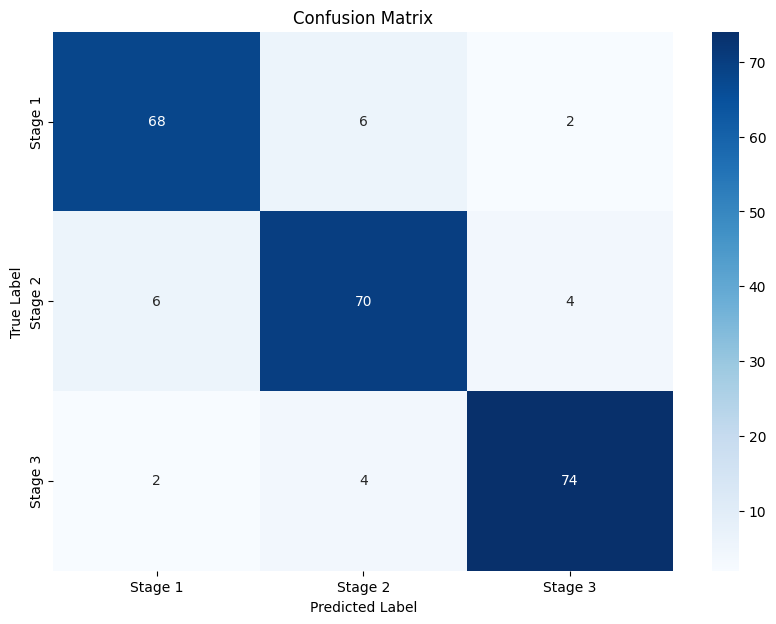

In [25]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Function to evaluate the model on the test set
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, conf_matrix

# Function to display confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
# Assuming 'model' is your trained model and 'dataloaders['val']' is your test/validation dataloader.
device = torch.device("cuda")
model.load_state_dict(torch.load(r'RegNet_3stages.pth', map_location=torch.device('cuda')))

accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, dataloaders['val'], device)

# Print metrics
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, dataset.classes)


## Stores the mis-classified images to a CSV file

In [ ]:
# import pandas as pd
# import numpy as np
# import torch
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Function to evaluate the model on the validation set and save misclassified images' details
# def evaluate_model_with_misclassifications(model, dataloader, device, dataset):
#     model.eval()  # Set model to evaluation mode
#     all_labels = []
#     all_preds = []
#     misclassified_data = []

#     with torch.no_grad():  # Disable gradient calculation
#         for inputs, labels, paths in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
            
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())
            
#             # Check for misclassifications and collect their details
#             for i in range(len(labels)):
#                 if preds[i] != labels[i]:  # Misclassified
#                     image_path = paths[i]
#                     original_label = dataset.classes[labels[i].item()]
#                     predicted_label = dataset.classes[preds[i].item()]
#                     misclassified_data.append([os.path.basename(image_path), original_label, predicted_label])

#     # Convert lists to numpy arrays
#     all_labels = np.array(all_labels)
#     all_preds = np.array(all_preds)
    
#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='weighted')
#     recall = recall_score(all_labels, all_preds, average='weighted')
#     f1 = f1_score(all_labels, all_preds, average='weighted')
    
#     # Confusion matrix
#     conf_matrix = confusion_matrix(all_labels, all_preds)
    
#     # Save misclassified data to CSV
#     df = pd.DataFrame(misclassified_data, columns=['Image Name', 'Original Label', 'Predicted Label'])
#     df.to_csv('misclassified_images.csv', index=False)
    
#     return accuracy, precision, recall, f1, conf_matrix

# # Example usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('ResNet50_AllStagesSuperposed_TL.pth', map_location=device))
# model.to(device)  # Ensure model is on the correct device

# # Custom dataset class
# class CustomImageFolder(datasets.ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super().__getitem__(index)
#         path = self.imgs[index][0]
#         return (*original_tuple, path)

# # Load only validation dataset
# data_dir = 'Data_superposed'  # Replace with your directory path
# dataset_with_paths = CustomImageFolder(data_dir, transform=data_transforms)

# # Create DataLoader for the validation set only
# dataloaders_with_paths = {
#     'val': DataLoader(dataset_with_paths, batch_size=32, shuffle=False, num_workers=0)  # Change num_workers for debugging
# }

# # Evaluate the model on the validation dataset
# accuracy, precision, recall, f1, conf_matrix = evaluate_model_with_misclassifications(model, dataloaders_with_paths['val'], device, dataset_with_paths)

# # Print metrics
# print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# # Assuming plot_confusion_matrix is defined
# plot_confusion_matrix(conf_matrix, dataset_with_paths.classes)




In [ ]:
# from sklearn.model_selection import KFold
# import torch
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Define evaluate_metrics function
# def evaluate_metrics(preds, labels):
#     metrics = {}
#     metrics['accuracy'] = accuracy_score(labels, preds)
#     metrics['precision'] = precision_score(labels, preds, average='weighted')  # Use 'macro' for class balance
#     metrics['recall'] = recall_score(labels, preds, average='weighted')
#     metrics['f1_score'] = f1_score(labels, preds, average='weighted')
#     return metrics


# # Define k-fold cross-validation function
# def k_fold_cross_validation(model, dataset, k=5, batch_size=32, device='cuda'):
#     # Initialize KFold with k splits
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#     fold_metrics = {
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'f1_score': []
#     }
    
#     for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
#         print(f'Fold {fold + 1}/{k}')
        
#         # Define subsets for training and validation for this fold
#         train_subset = torch.utils.data.Subset(dataset, train_idx)
#         val_subset = torch.utils.data.Subset(dataset, val_idx)
        
#         # Create DataLoaders
#         train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#         val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
#         # Reset model weights for each fold
#         model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        
#         # Set up optimizer and loss function
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#         criterion = torch.nn.CrossEntropyLoss()
        
#         # Training loop for the current fold
#         for epoch in range(10):  #Ensure num_epochs is defined
#             model.train()
#             for images, labels in train_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
        
#         # Validation loop
#         model.eval()
#         metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
        
#         # Use tqdm to track validation progress
#         with torch.no_grad():
#             for images, labels in tqdm(val_loader, desc=f'Validating Fold {fold + 1}'):
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, preds = torch.max(outputs, 1)
                
#                 # Assuming evaluate_metrics function calculates metrics per batch
#                 batch_metrics = evaluate_metrics(preds.cpu(), labels.cpu())
                
#                 # Sum metrics for this fold
#                 for key in metrics:
#                     metrics[key] += batch_metrics[key]
        
#         # Average metrics for the fold
#         for key in metrics:
#             metrics[key] /= len(val_loader)
#             fold_metrics[key].append(metrics[key])
    
#     # Calculate and return the average metrics across all folds
#     avg_metrics = {key: sum(values) / k for key, values in fold_metrics.items()}
#     return avg_metrics

# # Usage example (replace model and dataset with your specific instances):
# avg_metrics = k_fold_cross_validation(model, dataloaders['val'], k=5, batch_size=4, device='cuda')
# print(avg_metrics)


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import torch
# import numpy as np
# import warnings
# warnings.filterwarnings('ignore')

# # Parameters
# k_folds = 3
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Prepare k-fold cross-validation
# kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Store metrics for each fold
# fold_accuracies = []
# fold_precisions = []
# fold_recalls = []
# fold_f1_scores = []

# # Loop through each fold
# for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
#     print(f"FOLD {fold + 1}")
#     print("================================")

#     # Split data for this fold
#     val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
#     val_loader = dataloaders['val']

#     # Load stored model
#     model.load_state_dict(torch.load(r'ResNet_Models\ResNet50_3StagesSuperposed_TL.pth', map_location=torch.device('cuda'))) # Replace with your model's path
#     model.eval()  # Set model to evaluation mode

#     # Validation loop
#     val_preds = []
#     val_labels = []
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             val_preds.extend(preds.cpu().numpy())
#             val_labels.extend(labels.cpu().numpy())

#     # Compute metrics for this fold
#     accuracy = accuracy_score(val_labels, val_preds)
#     precision = precision_score(val_labels, val_preds, average='weighted')
#     recall = recall_score(val_labels, val_preds, average='weighted')
#     f1 = f1_score(val_labels, val_preds, average='weighted')

#     print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
#     fold_accuracies.append(accuracy)
#     fold_precisions.append(precision)
#     fold_recalls.append(recall)
#     fold_f1_scores.append(f1)

# # Display average metrics
# print("================================")
# print("K-FOLD CROSS VALIDATION RESULTS FOR {} FOLDS".format(k_folds))
# print("Average Accuracy: {:.4f}".format(np.mean(fold_accuracies)))
# print("Average Precision: {:.4f}".format(np.mean(fold_precisions)))
# print("Average Recall: {:.4f}".format(np.mean(fold_recalls)))
# print("Average F1 Score: {:.4f}".format(np.mean(fold_f1_scores)))
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Parameters
k_folds = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare k-fold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"FOLD {fold + 1}")
    print("================================")

    # Split data for this fold
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    val_loader = dataloaders['val']  # Make sure to create a new DataLoader for validation

    # Load stored model
    model.load_state_dict(torch.load(r'ResNet_Models\ResNet50_Rop_NoRop_acc9250.pth', map_location=device))  # Replace with your model's path
    model.eval()  # Set model to evaluation mode

    # Validation loop
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Compute metrics for this fold
    accuracy = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='weighted')
    recall = recall_score(val_labels, val_preds, average='weighted')
    f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Display average metrics and their standard deviations
print("================================")
print("K-FOLD CROSS VALIDATION RESULTS FOR {} FOLDS".format(k_folds))
print("Average Accuracy: {:.4f} ± {:.4f}".format(np.mean(fold_accuracies), np.std(fold_accuracies)))
print("Average Precision: {:.4f} ± {:.4f}".format(np.mean(fold_precisions), np.std(fold_precisions)))
print("Average Recall: {:.4f} ± {:.4f}".format(np.mean(fold_recalls), np.std(fold_recalls)))
print("Average F1 Score: {:.4f} ± {:.4f}".format(np.mean(fold_f1_scores), np.std(fold_f1_scores)))
